### Exploritory Data Analysis:

**After I have done the basic data clean-up it was time to explore the data using different analytical plots. 
EDA is very important because it allows me to explore deeper into the dataset and find important quantities, features, and correlations. With the help of these findings not only would I be able to supply my future machine learning models with higher data quality but also, reinforce one's knowledge on the general performance of the product to which the data is related to**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#importing the data
movie_metadata = pd.read_csv("movies_md.csv")
ratings = pd.read_csv("ratings_nw.csv")

In [3]:
#creating copies of the data sets
mmd = movie_metadata.copy()
rts = ratings.copy()

In [4]:
#renaming the 'id' column to 'movieId' for convenience
mmd.rename(columns={"id": "movieId"}, inplace=True)

In [5]:
#Merging movies data and ratings data on 'movieId' column 
movie_data = pd.merge(rts, mmd, on='movieId')

In [6]:
movie_data.head()

userId  movieId  rating   timestamp                           genres  \
0       1      110     1.0  1425941529  ['Drama', 'Mystery', 'Romance']   
1      11      110     3.5  1231676989  ['Drama', 'Mystery', 'Romance']   
2      22      110     5.0  1111937009  ['Drama', 'Mystery', 'Romance']   
3      24      110     5.0   979870012  ['Drama', 'Mystery', 'Romance']   
4      29      110     3.0  1044020005  ['Drama', 'Mystery', 'Romance']   

               title  
0  Three Colors: Red  
1  Three Colors: Red  
2  Three Colors: Red  
3  Three Colors: Red  
4  Three Colors: Red

In [7]:
# Basic Analysis 
T = len(rts['userId'].unique()) # Total number of registered users
TA = len(movie_data['userId'].unique()) # Total number of active users
C = movie_data['rating'].mean() # Global average rating   
AM = len(mmd['title'].unique()) # Total amount of movies on the platform
WAM = len(movie_data['title'].unique()) # Amount of movies watched atleast by 1 user (has atleast 1 vote)
TV = movie_data['userId'].count() # Total number of votes 
MGR1 = movie_data.groupby('userId')['rating'].count().max() # Maximum votes given by a user
MGR2 = movie_data.groupby('userId')['rating'].count().min() # Minimum votes given by a user

print("Total number of registered users: {}".format(T))
print("Total number of active users: {}".format(TA))
print("Global average rating: {:.2f}".format(C))
print("Total amount of movies on the platform: {}".format(AM))
print("Total amount of movies with atleast 1 vote: {}".format(WAM))
print("Total number of registered votes: {}".format(TV))
print("Maximum votes given by a user {}".format(MGR1))
print("Minimum votes given by a user {}".format(MGR2))

Total number of registered users: 270896
Total number of active users: 265917
Global average rating: 3.53
Total amount of movies on the platform: 42277
Total amount of movies with atleast 1 vote: 7409
Total number of registered votes: 11436568
Maximum votes given by a user 3593
Minimum votes given by a user 1


#### insights:
**1.** There are 4979 users that did not vote<br>
**2.** The overall movie quality is above average and/or users are pretty generous when it comes to rating<br>
**3.** Each active user voted 40 times on average<br>
**4.** Only 17% of movies on the platform have atleast 1 vote

In [8]:
# Advanced Analysis 
# creating a new dataframe which consists of movie titles, average rating for the movie and total number of votes for the movie
ratings_avg_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_avg_count['number_of_votes'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_avg_count.head()

rating  number_of_votes
title                                           
!Women Art Revolution  2.802945              883
$1,000 on the Black    3.000000                1
$5 a Day               2.246795              156
'Gator Bait            3.443590              195
'R Xmas                2.627907               86

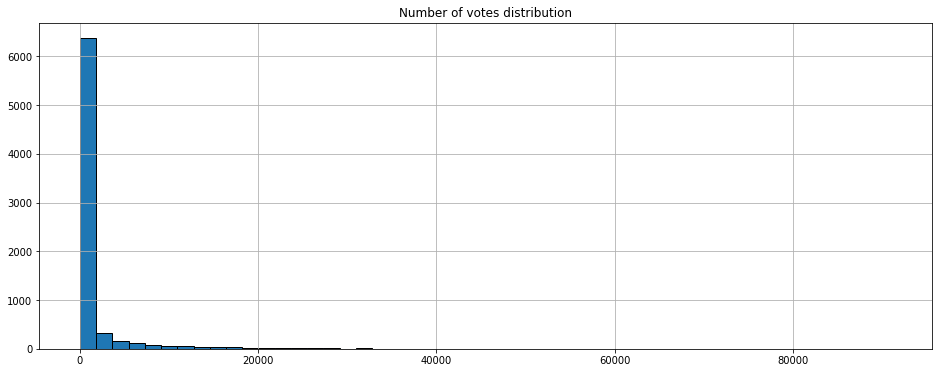

In [9]:
plt.figure(figsize=(16,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['number_of_votes'].hist(bins=50)
plt.title("Number of votes distribution")
plt.show()

**Most of the movies on the platform have around 50 votes**

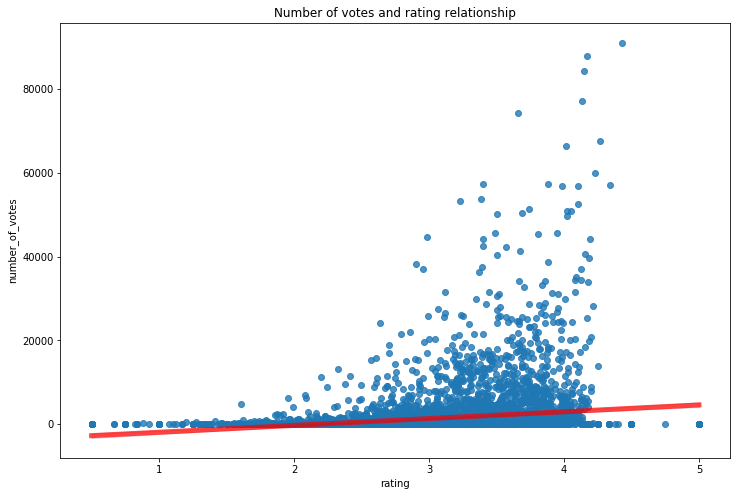

In [10]:
plt.figure(figsize=(12,8))
sns.regplot(x='rating', y='number_of_votes',data=ratings_avg_count, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title("Number of votes and rating relationship")
plt.show()

**There is a slight positive correlation between the average rating of a movie and the number of votes. According to the graph:<br> 1. Movies with higher average ratings actually have more number of ratings.**<br>
**2. If a movie gets more number of votes, the average rating would increase slightly**

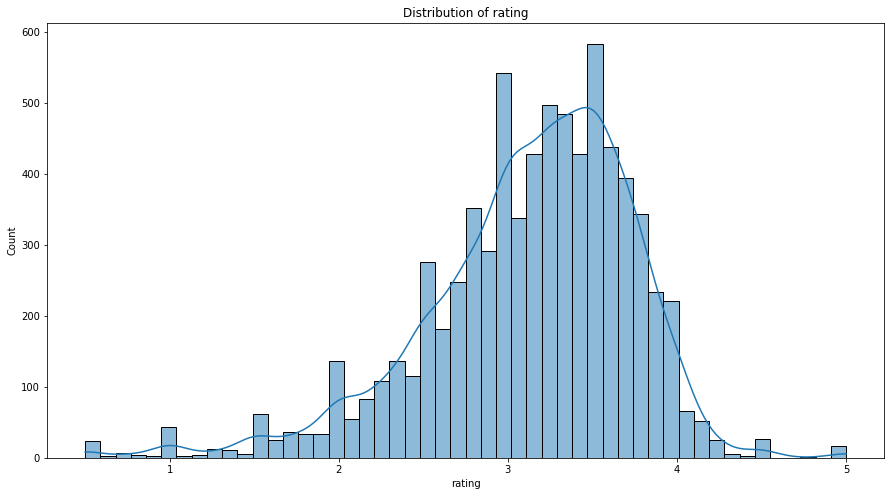

In [11]:
plt.figure(figsize=(15,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_avg_count, x="rating",bins=50, kde=True)
plt.title("Distribution of rating")
plt.show()

**According to the graph the data has a weak normal distribution with the mean around 3.5 due to the presence of outliers in the data. In addition, values of format x and x.5 (where x is a number between 0 - 5) are assigned by users much more often than other float values**

## Creating a Top 10 Movie List <a id='metric'></a>

**In order to create a top 10 movie list I will use IMDb's formula for computing the movie's weighted rate and use it as the movie's score.** <br>

### Why IMDb's Formula?

**I will use IMDb's formula because the basic idea behind it is, that it treats each voter as a "naive-individual" with no previous experieces. Hence, if a movie has many votes, each voter's vote is more trustable which leads to the rate to be higher. On the other hand, if a movie has less votes, each voter's vote is less trustable, which leads to the rate to be lower.**

### The Formula:

**WR = (v/(v+m)) * R + (m/(v+m)) * C** 

*Where:*

**R** = Average for the movie as a number from 0 - 5<br>
**v** = Number of votes for the movie<br>
**m** = Minimum votes required to be listed in the top 250 (according to imdb: 25,000)<br>
**C** = The mean vote across the whole report 

### Finding  m for MovieLens platform:

**I cannot use the m value of IMDb because:**<br>
1. It is a threshold for top 250 movies. <br>
2. IMDb has 83 million users while while the platform has 270,000.<br>

**As a result, I need to scale it to be suitable for the amount of users which are on the MovieLens platform.**

**1.** Find the ratio between total number of users on IMDb (Tu1) and (m1): 83,000,000 : 25,000 --> [3320 : 1].<br> 
**2.** Find the ratio between total number of users on the platform (Tu2) and (m2) : m2 : 270,896. <br>
**3.** Compare both ratios and solve the equation for m2: 3320 * m2 = 270,896 * 1 --> **m2 = 82**. <br>

**Now that I have the minimum votes required to be listed in the top 250 in the MovieLens platform I can calculate the weighted rate for each movie, create the a list of top 250 by filtering all the movies which have less than 82 votes and lastly from that list creating another list of Top 10 movies**

### Calculation

In [12]:
#Creating m, C 
m = 82
C = 3.53

#I filter the movies with less than 82 votes
filtered_movies = ratings_avg_count.loc[ratings_avg_count['number_of_votes'] >= m]

#creating a function that will compute the rating for each movie
def weighted_rate(data, m=m, C=C):
    R = data['rating']
    v = data['number_of_votes']
    wr =  (v/(v+m) * R) + (m/(m+v) * C)
    return wr

filtered_movies['weighted_rate'] = filtered_movies.apply(weighted_rate, axis=1)
filtered_movies = filtered_movies.sort_values('weighted_rate', ascending=False)

### Top 10 Movies with adjusted IMDb metric:

In [13]:
filtered_movies.head(10)

rating  number_of_votes  weighted_rate
title                                                                     
The Million Dollar Hotel          4.429015            91082       4.428206
Sleepless in Seattle              4.339811            57070       4.338649
Once Were Warriors                4.266531            67662       4.265639
Hard Target                       4.255074            13994       4.250850
License to Wed                    4.230716            60024       4.229760
Murder She Said                   4.213030            28280       4.211056
Cousin, Cousine                   4.202589            20855       4.199955
Dead Man                          4.200820             7930       4.193954
A Woman, a Gun and a Noodle Shop  4.199039             8948       4.192963
The Thomas Crown Affair           4.189107            44324       4.187890

## Data preperation (movie genres feature not available)

**I will be building a Recommenders System using Item-Based Collaborative Filtering. I use Collaborative Filtering because I do not have any information about the users except their rating (timestamp in my opinion does not give any valuable information because it only captures the vote date of the user) and about the movies except their title. In addition, I use Item-Based approach because my data has more users than movies, it is faster and more reliable (the average rating received by an item usually does not change as quickly as the average rating given by a user to different items)**

**I will construct a User X Movie matrix and claculate the sparsity of the matrix to decide which approach I should be using: Memory Based, Model Based**

In [15]:
#creating the matrix
UM = sample.pivot_table(index=['userId'], columns=['title'], values=['rating'])
UM

rating                               \
title  !Women Art Revolution $5 a Day 'Gator Bait 'R Xmas   
userId                                                      
1                        NaN      NaN         NaN     NaN   
2                        NaN      NaN         NaN     NaN   
3                        NaN      NaN         NaN     NaN   
4                        NaN      NaN         NaN     NaN   
5                        NaN      NaN         NaN     NaN   
...                      ...      ...         ...     ...   
270892                   NaN      NaN         NaN     NaN   
270893                   NaN      NaN         NaN     NaN   
270894                   NaN      NaN         NaN     NaN   
270895                   NaN      NaN         NaN     NaN   
270896                   NaN      NaN         NaN     NaN   

                                                                            \
title  'Twas the Night Before Christmas (A)Sexual ...And God Created Woman   
userId                                                                       
1                                   NaN       NaN                      NaN   
2                                   NaN       NaN                      NaN   
3                                   NaN       NaN                      NaN   
4                                   NaN       NaN                      NaN   
5                                   NaN       NaN                      NaN   
...                                 ...       ...                      ...   
270892                              NaN       NaN                      NaN   
270893                              NaN       NaN                      NaN   
270894                              NaN       NaN                      NaN   
270895                              NaN       NaN                      NaN   
270896                              NaN       NaN                      NaN   

                                                                             \
title  ...And the Pursuit of Happiness 00 Schneider - Jagd auf Nihil Baxter   
userId                                                                        
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   
5                                  NaN                                  NaN   
...                                ...                                  ...   
270892                             NaN                                  NaN   
270893                             NaN                                  NaN   
270894                             NaN                                  NaN   
270895                             NaN                                  NaN   
270896                             NaN                                  NaN   

                         ...                                              \
title  10 Items or Less  ... ¡A volar joven! ¡Three Amigos! À nos amours   
userId                   ...                                               
1                   NaN  ...             NaN            NaN          NaN   
2                   NaN  ...             NaN            NaN          NaN   
3                   NaN  ...             NaN            NaN          NaN   
4                   NaN  ...             NaN            NaN          NaN   
5                   NaN  ...             NaN            NaN          NaN   
...                 ...  ...             ...            ...          ...   
270892              NaN  ...             NaN            NaN          NaN   
270893              NaN  ...             NaN            NaN          NaN   
270894              NaN  ...             NaN            NaN          NaN   
270895              NaN  ...             NaN           

### Sparsity Calculation Formula:  S = 1 - (count_nonzero(M) / total_elements_of_M)

In [16]:
#calculating the sparsity of the matrix
S = 1 - (np.sum(UM.count()) / (len(UM.axes[0]) * len(UM.axes[1])))
S

0.9968006365066787

###### **The matrix is 99.7% sparse which means that 99.7% is empty (has no rating). For this reason, I am more determined to use the Item-Based approach as it has proven to have good results with sparse data**

## Data Preprocessing

**Before applying any machine learning model I will do the following steps:**

**Split the data into training and testing sets.**<br>
**Normalize the data.**<br>

**I split the data to train and test sets before applying normalization in order to avoid data leakage and normalize the data in-order to reduce the influence of outliers and help the models to converge faster. In my case the outliers are users that always give high ratings (the optimists) and users that always give low ratings (the pessimists)**

In [22]:
Um_train, Um_test = train_test_split(UM, test_size=0.1, random_state=1)